In [1]:
import regex
import pandas as pd
from typing import List
from importlib import reload

import utils
reload(utils)

from utils import Bill, BillProcessor, CorpusProcessor, load_bills

#### 1. Regular expressions for three different types of ammendments

In [2]:
class RawPatterns:
    _units = [
        "lit",
        r"(nowy\s+)?pkt",
        "art",
        "tiret",
        "ust",
        r"rozdzia[lł]y?",
        r"dzia[lł]y?",
        r"oddzia[lł]y?"
        r"preambu\p{L}{2}",
        r"za[lł][aą]cznik",
        "poz",
        r"§(?:[\w]+)?"
    ]

    YEAR = r"z\s+dnia\s+\d{1,2}\s+\w+\s+(\d{4})"
    UNTIS = r"(" + "|".join(_units) + r")\.?"
    UNIT_ID = r"(:?\w+)"

    ADD_BASE = r"\bdodaj\p{L}\s+si\p{L}\s+"
    REM_BASE = r"(?:\bskre\p{L}la|\buchyla)\s+si\p{L}\s+"
    MOD_BASE = r"\botrzymuje\s+brzmienie\b"

    ANY_PHRASE_AFTER_ADD_BASE = ADD_BASE + r"([^\s]+)\b"
    ANY_PHRASE_AFTER_REM_BASE = REM_BASE + r"([^\s]+)\b"

In [3]:
class PatternStore:
    YEAR = regex.compile(RawPatterns.YEAR, regex.I)

    ANY_PHRASE_AFTER_ADD = regex.compile(RawPatterns.ANY_PHRASE_AFTER_ADD_BASE, regex.I)
    ANY_PHRASE_AFTER_REM = regex.compile(RawPatterns.ANY_PHRASE_AFTER_REM_BASE, regex.I)
    UNIT_ADD = regex.compile(RawPatterns.ADD_BASE + RawPatterns.UNTIS, regex.I)
    UNIT_REM = regex.compile(RawPatterns.REM_BASE + RawPatterns.UNTIS, regex.I)
    UNIT_MOD = regex.compile(
        RawPatterns.UNTIS + r"\s+?" + RawPatterns.UNIT_ID + r"\s+?" + RawPatterns.MOD_BASE,
        regex.I
    )

#### Methodology of RawExpressions.UNITS creation

In [4]:
potential_units = []

for bill in load_bills():
    result = PatternStore.ANY_PHRASE_AFTER_ADD.findall(bill.content) +\
        PatternStore.ANY_PHRASE_AFTER_REM.findall(bill.content)
    potential_units += result

print(set(potential_units))

{'oraz', 'na', 'ustawę', 'cyfrę', 'litery', 'po', 'wyrazy', 'lit', 'art', 'ust.4', 'drugie', 'lit.d)-f', 'załącznik', 'punkt', '§1a', 'pozycję', 'lit.f', 'Dział', 'tytuł', '11', 'lub', 'oddział', 'ust.11', 'art.7a', 'dwukrotnie', 'art.42', 'nowe', 'zadanie', 'zdanie', 'informację', 'nowy', 'zdania', 'ust', 'ust.10a', 'i', 'poz', 'preambułę', 'ust.7a', 'dział', 'art.59', '2a', 'od', 'trzecie', 'masę', 'lit.d', 'użyte', 'ust.5a', '5a', 'ostatnie', 'kropkę', 'trzykrotnie', '2', 'rozdział', '38a-38c', 'dwukropek', 'rozdziały', 'ozna\xadczenie', 'lit.c', 'tiret', 'w', 'lp', 'ust.3a', 'niezwłocznie', '§3', 'kwotę', 'Oddział', '1-4', 'decyzję', 'usta', '4', '§2', 'ust.5', 'Rozdział', 'powołanie', 'wraz', 'średnik', 'użyty', 'pkt', 'oznaczenie', 'ust.1a', 'przecinek', 'z', 'ust.10', 'odnośnik', 'przyimek', '3', 'każdorazowo', 'decyzje', 'ust.3', 'wyraz', 'pozostałą', 'ust.10a"10h', 'określenie'}


In [5]:
class NormalizationProcessor(BillProcessor):
    def _reduce_whitespaces(content: str):
        return regex.sub(r"\s+", " ", content)

    @classmethod
    def process(cls, content: str): # bills.content todo
        return cls._reduce_whitespaces(content)


class PublishmentYearProcessor(BillProcessor):
    def _find_publishment_year(content: str):
        return PatternStore.YEAR.search(content.lower()).group(1)

    @classmethod
    def process(cls, content: str):
        return cls._find_publishment_year(content)


class AdditionsCountProcessor(BillProcessor):
    def _count_additions(content: str):
        return len(PatternStore.UNIT_ADD.findall(content))

    @classmethod
    def process(cls, content: str):
        return cls._count_additions(content)


class RemovalsCountProcessor(BillProcessor):
    def _count_removals(content: str):
        return len(PatternStore.UNIT_REM.findall(content))

    @classmethod
    def process(cls, content: str):
        return cls._count_removals(content)


class ModificationsCountProcessor(BillProcessor):
    def _count_modifications(content: str):
        return len(PatternStore.UNIT_MOD.findall(content))

    @classmethod
    def process(cls, content: str):
        return cls._count_modifications(content)

In [6]:
bills = load_bills()

ammendments_processor = CorpusProcessor(
    bills=bills,
    processors=[
        NormalizationProcessor,
        PublishmentYearProcessor,
        AdditionsCountProcessor,
        RemovalsCountProcessor,
        ModificationsCountProcessor,
    ]
)

In [7]:
df = ammendments_processor()
df.columns = [
    "filename",
    "content",
    "year",
    "additions",
    "removals",
    "changes",
]

df.head()

,filename,content,year,additions,removals,changes
0,2001_874.txt,"Dz.U. z 2001 r. Nr 81, poz. 874 USTAWA z dnia...",2001,0,0,1
1,1996_583.txt,"Dz.U. z 1996 r. Nr 124, poz. 583 USTAWA z dni...",1996,0,1,2
2,2003_1853.txt,"Dz.U. z 2003 r. Nr 189, poz. 1853 U S T A W A...",2003,13,1,28
3,1997_753.txt,"Dz.U. z 1997 r. Nr 117, poz. 753 USTAWA z dni...",1997,4,0,5
4,2000_440.txt,"Dz.U. z 2000 r. Nr 39, poz. 440 USTAWA z dnia...",2000,0,0,0


#### 3. Ammendments - summary and visualization

In [8]:
df_annual = df.groupby('year')[[
    'additions',
    'removals',
    'changes',
]].sum()

df_annual['total_ammendments'] = df_annual.sum(axis=1)
df_annual['additions_rate'] = df_annual.additions / df_annual.total_ammendments * 100
df_annual['removals_rate'] = df_annual.removals / df_annual.total_ammendments * 100
df_annual['changes_rate'] = df_annual.changes / df_annual.total_ammendments * 100

In [9]:
df_annual[['additions_rate', 'removals_rate', 'changes_rate']].head()

,additions_rate,removals_rate,changes_rate
year,,,
1993,34.615385,6.730769,58.653846
1994,44.444444,17.676768,37.878788
1995,39.450867,12.138728,48.410405
1996,32.254464,16.741071,51.004464
1997,34.597156,13.191153,52.211690


Text(0.5, 1.0, 'Percentage of amendments changes in time')

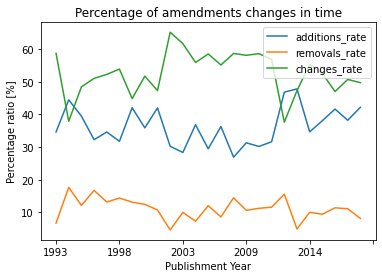

In [10]:
ax = df_annual[['additions_rate', 'removals_rate', 'changes_rate']].plot()
ax.set_xlabel("Publishment Year")
ax.set_ylabel("Percentage ratio [%]")
ax.set_title("Percentage of amendments changes in time")

Text(0.5, 1.0, 'Percentage of amendments changes in time')

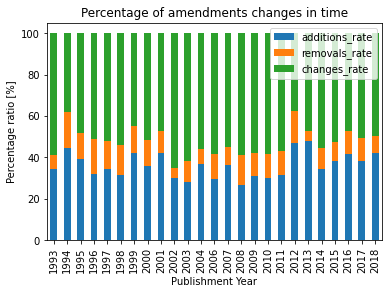

In [11]:
ax = df_annual[['additions_rate', 'removals_rate', 'changes_rate']].plot.bar(stacked=True)
ax.set_xlabel("Publishment Year")
ax.set_ylabel("Percentage ratio [%]")
ax.set_title("Percentage of amendments changes in time")

#### 4. Compute the total number of occurences of the word "ustawa" in any inflectional form and all spelling forms

In [12]:
class UstawaAllFormsProcesor:
    FORMS = []

    @classmethod
    def _count_all_forms(cls, content: str) -> int:
        _forms = regex.compile(
            r"\bustaw(?:\p{L}|ie|om|ach|ami|owy)?\b",
            regex.I
        ).findall(content)

        cls.FORMS += _forms
        return len(_forms)

    @classmethod
    def process(cls, content: str) -> int:
        return cls._count_all_forms(content)

#### 5. Compute the total number of occurences of the word ustawa (same conditions), followed by "z dnia" expression

In [13]:
class UstawaAllFollowedByProcessor:
    def _count_all_forms_followed_by(content: str) -> int:
        return len(regex.compile(
            r"(\bustaw(?:\p{L}|ie|om|ach|ami|owy)?\b)(?=\s+z\s+dnia\b)",
            regex.I
        ).findall(content))

    @classmethod
    def process(cls, content: str) -> int:
        return cls._count_all_forms_followed_by(content)

#### 6. As above, but not followed by "z dnia" expression

In [14]:
class UstawaAllNotFollowedByProcessor:
    def _count_all_forms_not_followed_by(content: str) -> int:
        return len(regex.compile(
            r"(\bustaw(?:\p{L}|ie|om|ach|ami|owy)?\b)(?!\s+z\s+dnia\b)",
            regex.I
        ).findall(content))

    @classmethod
    def process(cls, content: str) -> int:
        return cls._count_all_forms_not_followed_by(content)

#### 7. Compute the total number of occurences of the word ustawa in any inflectional form, excluding occurences following o zmianie

In [15]:
class UstawaNotChangedProcessor:
    def _count_not_changed(content: str) -> int:
        return len(regex.compile(
            r"(?<!\bo\s+zmianie\b)\s+\bustaw(?:\p{L}|ie|om|ach|ami|owy)?\b",
            regex.I # comment not to include any spelling forms
        ).findall(content))

    @classmethod
    def process(cls, content: str) -> int:
        return cls._count_not_changed(content)

In [17]:
bills = load_bills()
ustawa_processor = CorpusProcessor(
    bills=bills,
    processors=[
        UstawaAllFormsProcesor,
        UstawaAllFollowedByProcessor,
        UstawaAllNotFollowedByProcessor,
        UstawaNotChangedProcessor,
    ]
)

df_ustawa = ustawa_processor()
df_ustawa.columns = [
    "filename",
    "all_forms",
    "z_dnia_followed",
    "z_dnia_not_followed",
    "not_changed"
]

In [18]:
df_ustawa[[
    "all_forms",
    "z_dnia_followed",
    "z_dnia_not_followed",
    "not_changed"
]].sum()

all_forms              24960
z_dnia_followed         8587
z_dnia_not_followed    16373
not_changed            24016
dtype: int64

Text(0.5, 1.0, 'Number of conditional occurencies for the word ustawa')

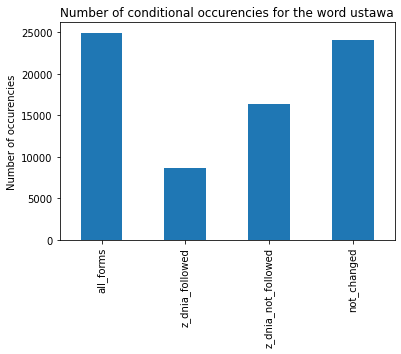

In [19]:
ax = df_ustawa[[
    "all_forms",
    "z_dnia_followed",
    "z_dnia_not_followed",
    "not_changed"
]].sum().plot.bar()
ax.set_ylabel("Number of occurencies")
ax.set_title("Number of conditional occurencies for the word ustawa")

#### Ad. 4 All inflectional and spelling forms of the word "ustawa"

In [20]:
set(UstawaAllFormsProcesor.FORMS)

{'USTAWA',
 'USTAWY',
 'USTAWa',
 'Ustaw',
 'Ustawa',
 'Ustawie',
 'Ustawowy',
 'Ustawy',
 'Ustawę',
 'ustaw',
 'ustawA',
 'ustawa',
 'ustawach',
 'ustawami',
 'ustawie',
 'ustawom',
 'ustawowy',
 'ustawy',
 'ustawą',
 'ustawę'}

#### Ad. 6 Check if the result is correct (Point 4 =? Point 5 + Point 6)

In [21]:
check = df_ustawa[[
    "all_forms",
    "z_dnia_followed",
    "z_dnia_not_followed" 
]].sum(axis=0).to_dict()

print(check)
assert check['all_forms'] == check['z_dnia_followed'] + check['z_dnia_not_followed']

{'all_forms': 24960, 'z_dnia_followed': 8587, 'z_dnia_not_followed': 16373}
